In [16]:
#import libraries
import torch
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import copy
import numpy as np
import os


In [17]:
def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape:
        size = shape
        
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    image = image.clip(0, 1)
    
    return image


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

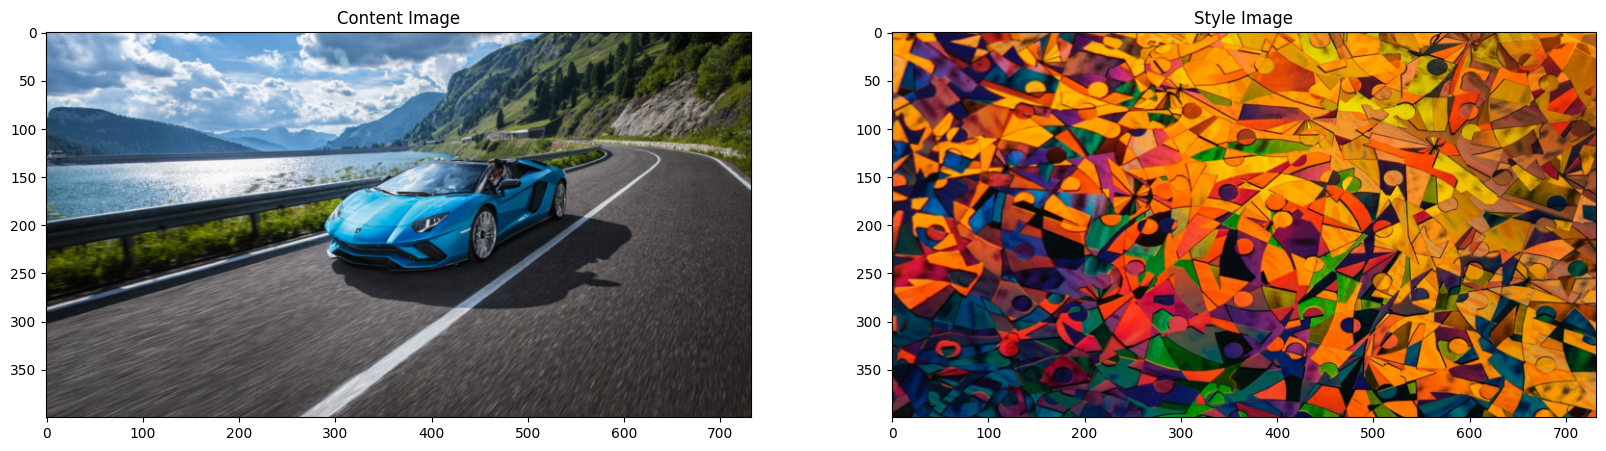

In [24]:


content = load_image('C:\\Users\\kasha\\Downloads\\content.jpg').to(device)
style = load_image('C:\\Users\\kasha\\Downloads\\style.jpg', shape=content.shape[-2:]).to(device)

# Display images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.set_title("Content Image")
ax2.imshow(im_convert(style))
ax2.set_title("Style Image")
plt.show()


In [7]:
vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features

# Freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [8]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # Content layer
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

# Get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Calculate the gram matrices for each layer of the style representation
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


In [9]:
# Content loss
def content_loss(target_features, content_features):
    return torch.mean((target_features - content_features)**2)

# Style loss
def style_loss(target_grams, style_grams):
    style_loss = 0
    for layer in target_grams:
        target_gram = target_grams[layer]
        style_gram = style_grams[layer]
        layer_loss = torch.mean((target_gram - style_gram)**2)
        style_loss += layer_loss
    return style_loss

# Total variation loss (optional, for smoothness)
def total_variation_loss(image):
    x_diff = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_diff = image[:, :, :, 1:] - image[:, :, :, :-1]
    return torch.sum(torch.abs(x_diff)) + torch.sum(torch.abs(y_diff))


In [10]:
# Create a copy of the content image to be the target image
target = content.clone().requires_grad_(True).to(device)

# Define optimizer
optimizer = optim.Adam([target], lr=0.003)


Step 0, Total Loss: 627015424.0


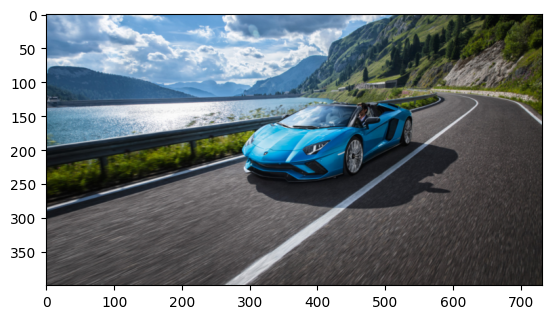

Step 500, Total Loss: 69824248.0


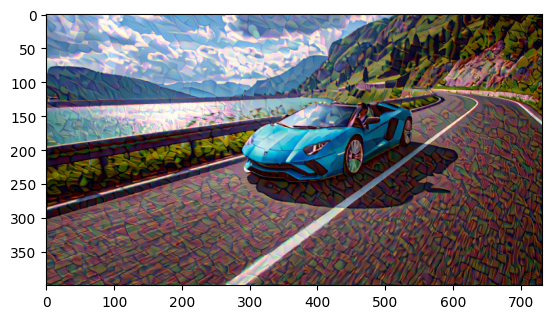

Step 1000, Total Loss: 32669162.0


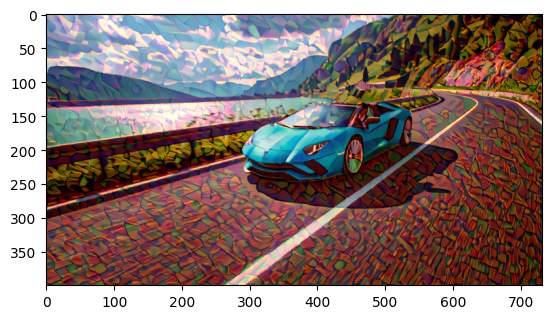

Step 1500, Total Loss: 15762335.0


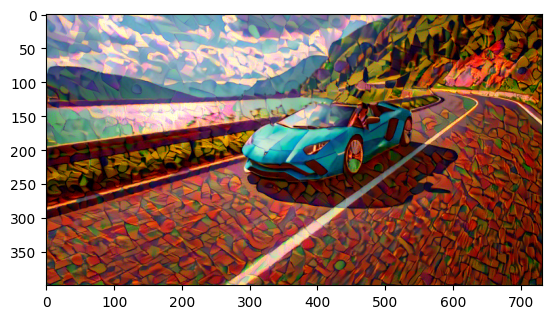

In [11]:
# Number of steps
steps = 2000

# Weights for content and style losses
content_weight = 1e3
style_weight = 1e-2

for step in range(steps):
    target_features = get_features(target, vgg)
    target_grams = {layer: gram_matrix(target_features[layer]) for layer in target_features}
    
    c_loss = content_loss(target_features['conv4_2'], content_features['conv4_2'])
    s_loss = style_loss(target_grams, style_grams)
    tv_loss = total_variation_loss(target)
    
    total_loss = content_weight * c_loss + style_weight * s_loss + tv_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if step % 500 == 0:
        print(f"Step {step}, Total Loss: {total_loss.item()}")
        plt.imshow(im_convert(target))
        plt.show()


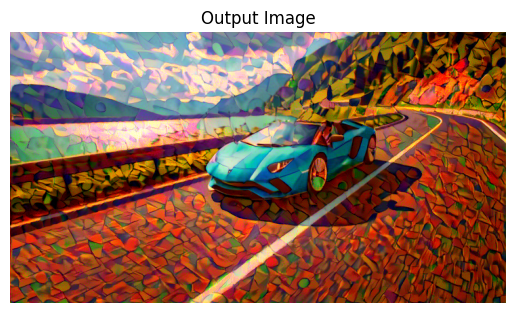

In [25]:

# Save and display the final image
final_image = im_convert(target)
plt.imshow(final_image)
plt.title("Output Image")
plt.axis("off")
plt.show()




In [15]:
# Save the image
output_path = "output_image.jpg"
final_image_pil = Image.fromarray((final_image * 255).astype(np.uint8))
final_image_pil.save(output_path)